# User Experience Analytics

## Imports

In [1]:
import numpy as np
import pandas as pd
from math import floor
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import zscore
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from df_selector import DfSelector
from df_outlier import DfOutlier
from vis_seaborn import *
from vis_plotly import *

2021-07-16 21:07:04,216 — DfSelector — DEBUG — Loaded successfully!
2021-07-16 21:07:04,223 — DfOutlier — DEBUG — Loaded successfully!


## Data reading

In [4]:
df = pd.read_csv("../data/clean_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146882 entries, 0 to 146881
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   bearer_id                       146882 non-null  int64  
 1   start                           146882 non-null  object 
 2   start_ms                        146882 non-null  float64
 3   end                             146882 non-null  object 
 4   end_ms                          146882 non-null  float64
 5   dur_(ms)                        146882 non-null  float64
 6   imsi                            146882 non-null  int64  
 7   msisdn_number                   146882 non-null  int64  
 8   imei                            146882 non-null  int64  
 9   last_location_name              146882 non-null  object 
 10  avg_rtt_dl_(ms)                 146882 non-null  float64
 11  avg_rtt_ul_(ms)                 146882 non-null  float64
 12  avg_bearer_tp_dl

## Task 3. 1

Aggregate, per customer, the following information(treat missing & outliers by replacing by the mean or the mode of the corresponding variable

- Average TCP retransmission
- Average RTT
- Handset type
- Average throughput

In [5]:
user_engagement_df = df[[
    "msisdn_number",
    "avg_rtt_dl_(ms)",
    "avg_rtt_ul_(ms)",
    "avg_bearer_tp_dl_(kbps)",
    "avg_bearer_tp_ul_(kbps)",
    "tcp_dl_retrans_vol_(bytes)",
    "tcp_ul_retrans_vol_(bytes)",
    "handset_type"]].copy()

In [6]:
user_engagement_df['total_avg_rtt'] = user_engagement_df['avg_rtt_dl_(ms)'] + user_engagement_df['avg_rtt_ul_(ms)']
user_engagement_df['total_avg_tp'] = user_engagement_df['avg_bearer_tp_dl_(kbps)'] + user_engagement_df['avg_bearer_tp_ul_(kbps)']
user_engagement_df['total_avg_tcp'] = user_engagement_df['tcp_dl_retrans_vol_(bytes)'] + user_engagement_df['tcp_ul_retrans_vol_(bytes)']
user_engagement_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146882 entries, 0 to 146881
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   msisdn_number               146882 non-null  int64  
 1   avg_rtt_dl_(ms)             146882 non-null  float64
 2   avg_rtt_ul_(ms)             146882 non-null  float64
 3   avg_bearer_tp_dl_(kbps)     146882 non-null  float64
 4   avg_bearer_tp_ul_(kbps)     146882 non-null  float64
 5   tcp_dl_retrans_vol_(bytes)  146882 non-null  float64
 6   tcp_ul_retrans_vol_(bytes)  146882 non-null  float64
 7   handset_type                146882 non-null  object 
 8   total_avg_rtt               146882 non-null  float64
 9   total_avg_tp                146882 non-null  float64
 10  total_avg_tcp               146882 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 12.3+ MB


In [7]:
_user_engagement_df = user_engagement_df.groupby('msisdn_number').agg({
    'total_avg_rtt': 'sum',
    'total_avg_tp': 'sum',
    'total_avg_tcp': 'sum',
    'handset_type': [lambda x: x.mode()[0]]})

user_engagement_df = pd.DataFrame(columns=[
    "total_avg_rtt",
    "total_avg_tp",
    "total_avg_tcp",
    "handset_type"])

user_engagement_df["total_avg_rtt"] = _user_engagement_df["total_avg_rtt"]['sum']
user_engagement_df["total_avg_tp"] = _user_engagement_df["total_avg_tp"]['sum']
user_engagement_df["total_avg_tcp"] = _user_engagement_df["total_avg_tcp"]['sum']
user_engagement_df["handset_type"] = _user_engagement_df["handset_type"]['<lambda>']
user_engagement_df.head()

,total_avg_rtt,total_avg_tp,total_avg_tcp,handset_type
msisdn_number,,,,
33601001722,46.00,76.00,729692.00,Huawei P20 Lite Huawei Nova 3E
33601001754,31.00,99.00,15743.00,Apple iPhone 7 (A1778)
33601002511,50.00,97.00,4032874.25,Huawei B528S-23A
33601007832,84.00,248.00,5056.00,Apple iPhone 5S (A1457)
33601008617,119.00,43204.50,8980965.88,Apple iPhone Se (A1723)


## Task 3.2 

Compute & list 10 of the top, bottom and most frequent:

### TCP values in the dataset.


In [20]:
sorted_by_tcp = user_engagement_df.sort_values('total_avg_tcp', ascending=False)
top_10 = sorted_by_tcp.head(10)['total_avg_tcp']
last_10 = sorted_by_tcp.tail(10)['total_avg_tcp']
most_10 = user_engagement_df['total_avg_tcp'].value_counts().head(10)

In [21]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "TCP values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

### RTT values in the dataset.


In [22]:
sorted_by_rtt = user_engagement_df.sort_values(
    'total_avg_rtt', ascending=False)
top_10 = sorted_by_rtt.head(10)['total_avg_rtt']
last_10 = sorted_by_rtt.tail(10)['total_avg_rtt']
most_10 = user_engagement_df['total_avg_rtt'].value_counts().head(10)


In [23]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "TCP values in the dataset", ['Top 10', 'Last 10', 'Most 10'])


### Throughput values in the dataset.


In [29]:
sorted_by_tp = user_engagement_df.sort_values(
    'total_avg_tp', ascending=False)
top_10 = sorted_by_tp.head(10)['total_avg_tp']
last_10 = sorted_by_tp.tail(10)['total_avg_tp']
most_10 = user_engagement_df['total_avg_tp'].value_counts().head(10)

In [30]:
mult_hist([top_10, last_10, most_10, top_10], 1,
          3, "TCP values in the dataset", ['Top 10', 'Last 10', 'Most 10'])

## Task 3.3

### The distribution of the average throughput  per handset type and provide interpretation for your findings.

In [37]:
handset_type_df = user_engagement_df.groupby('handset_type').agg(
    {'total_avg_tp': 'mean', 'total_avg_tcp': 'mean'})
handset_type_df.head()

,total_avg_tp,total_avg_tcp
handset_type,,
A-Link Telecom I. Cubot A5,23510.00,793127.00
A-Link Telecom I. Cubot Note Plus,6699.00,616213.00
A-Link Telecom I. Cubot Note S,8937.00,7781238.88
A-Link Telecom I. Cubot Nova,50549.25,137170.00
A-Link Telecom I. Cubot Power,50341.25,8041.00


In [52]:
sorted_by_tp = handset_type_df.sort_values(
    'total_avg_tp', ascending=False)
top_tp = sorted_by_tp['total_avg_tp']

In [57]:
hist(top_tp)


In [59]:
hist(top_tp.head(20))

### The average TCP retransmission view per handset type and provide interpretation for your findings.

In [ ]:
sorted_by_tcp = handset_type_df.sort_values(
    'total_avg_tcp', ascending=False)
top_tcp = sorted_by_tcp['total_avg_tcp']

In [61]:
hist(top_tcp)

In [62]:
hist(top_tcp.head(20))

### Task 3.4 
Using the experience metrics above, perform a k-means clustering(where k=3) to segment users into groups of experiences and provide a brief description of each cluster. (The description must define each group based on your understanding of the data)


In [68]:
experiance_metric_df = user_engagement_df[[
    "total_avg_rtt",
    "total_avg_tp",
    "total_avg_tcp"]].copy()
experiance_metric_df.head()

,total_avg_rtt,total_avg_tp,total_avg_tcp
msisdn_number,,,
33601001722,46.00,76.00,729692.00
33601001754,31.00,99.00,15743.00
33601002511,50.00,97.00,4032874.25
33601007832,84.00,248.00,5056.00
33601008617,119.00,43204.50,8980965.88


Check for outliers

<AxesSubplot:>

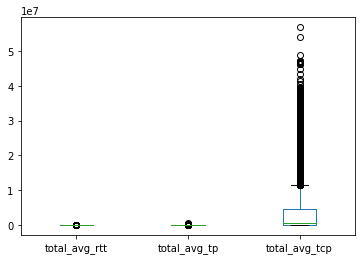

In [70]:
experiance_metric_df.plot.box()

In [71]:
df_outliers = DfOutlier(experiance_metric_df)
df_outliers.getOverview()

,Q1,median,Q3,IQR,skew,number_of_outliers,percentage_of_outliers,min_value,max_value,mean
label,,,,,,,,,,
total_avg_rtt,47.00,59.00,106.00,59.00,3.61,5623,5.32%,0.00,1094.00,83.30
total_avg_tp,97.00,302.00,25398.88,25301.88,3.27,4950,4.68%,0.00,445213.25,16659.82
total_avg_tcp,78086.75,661481.50,4622683.81,4544597.06,2.74,4152,3.93%,44.00,56842100.75,2873245.29


In [73]:
df_outliers.replace_outliers_with_iqr(
    ["total_avg_rtt",
     "total_avg_tp",
     "total_avg_tcp"])
df_outliers = DfOutlier(experiance_metric_df)
df_outliers.getOverview()

,Q1,median,Q3,IQR,skew,number_of_outliers,percentage_of_outliers,min_value,max_value,mean
label,,,,,,,,,,
total_avg_rtt,47.00,59.00,106.00,59.00,1.10,0,0.0%,0.00,194.50,77.14
total_avg_tp,97.00,302.00,25398.88,25301.88,1.22,0,0.0%,0.00,63351.69,14116.57
total_avg_tcp,78086.75,661481.50,4622683.81,4544597.06,1.18,0,0.0%,44.00,11439579.41,2618383.02


<AxesSubplot:>

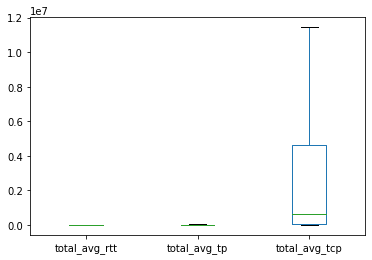

In [74]:
experiance_metric_df.plot.box()


In [75]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_outliers.df)
scaled_array
pd.DataFrame(scaled_array)

,0,1,2
0,-0.68,-0.68,-0.55
1,-1.01,-0.68,-0.76
2,-0.60,-0.68,0.41
3,0.15,-0.67,-0.76
4,0.92,1.41,1.85
...,...,...,...
105709,-0.53,-0.68,-0.76
105710,0.92,1.87,-0.76
105711,-0.55,-0.18,-0.70
105712,-0.82,-0.68,1.48


In [76]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(scaled_array)
kmeans.labels_

array([0, 0, 0, ..., 0, 2, 0], dtype=int32)

In [77]:
experiance_metric_df.insert(0, 'cluster', kmeans.labels_)
experiance_metric_df

,cluster,total_avg_rtt,total_avg_tp,total_avg_tcp
msisdn_number,,,,
33601001722,0,46.00,76.00,729692.00
33601001754,0,31.00,99.00,15743.00
33601002511,0,50.00,97.00,4032874.25
33601007832,0,84.00,248.00,5056.00
33601008617,1,119.00,43204.50,8980965.88
...,...,...,...,...
33789967113,0,53.00,67.00,2833.00
33789980299,1,119.00,52862.75,11809.00
33789996170,0,52.00,10365.00,218045.00


In [78]:
experiance_metric_df['cluster'].value_counts()


0    67004
1    22016
2    16694
Name: cluster, dtype: int64

In [81]:
fig = px.scatter(experiance_metric_df, x='total_avg_rtt', y="total_avg_tp",
                 color='cluster', size='total_avg_tcp')
fig.show()


ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['total_avg_rtt', 'total_avg_tp', 'total_avg_tcp', 'handset_type'] but received: cluster

In [80]:
# scatter3D(experiance_metric_df, x="total_avg_rtt", y="total_avg_tp", z="total_avg_tcp",
#           c="cluster")